In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

DATA_PATH = "../donnees/ecommerce/"

In [21]:
# Chargement du parquet F_ACHATS créé dans l'analyse 1
F_ACHATS = pd.read_parquet("f_achats.parquet")

print("F_ACHATS chargé depuis f_achats.parquet")
print("Shape :", F_ACHATS.shape)
print("Colonnes :", list(F_ACHATS.columns))
display(F_ACHATS.head(3))

F_ACHATS chargé depuis f_achats.parquet
Shape : (112650, 13)
Colonnes : ['order_item_id', 'order_id', 'product_id', 'seller_id', 'customer_id', 'zip_code', 'purchase_timestamp', 'order_status', 'price', 'freight_value', 'line_revenue', 'line_total', 'limit']


,order_item_id,order_id,product_id,seller_id,customer_id,zip_code,purchase_timestamp,order_status,price,freight_value,line_revenue,line_total,limit
0,1,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,3ce436f183e68e07877b285a838db11a,28013,2017-09-13 08:59:02,delivered,58.9,13.29,58.9,72.19,144.775833
1,1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,f6dd3ec061db4e3987629fe6b26e5cce,15775,2017-04-26 10:53:06,delivered,239.9,19.93,239.9,259.83,168.201944
2,1,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,6489ae5e4333f3693df5ad4372dab6d3,35661,2018-01-14 14:33:31,delivered,199.0,17.87,199.0,216.87,96.249722


In [22]:
# Recréation des dimensions de temps (locales, non sauvegardées dans le parquet)
F_ACHATS["year"]  = F_ACHATS["purchase_timestamp"].dt.year
F_ACHATS["month"] = F_ACHATS["purchase_timestamp"].dt.month
F_ACHATS["date"]  = F_ACHATS["purchase_timestamp"].dt.normalize()
F_ACHATS["week"]   = F_ACHATS["purchase_timestamp"].dt.isocalendar().week
F_ACHATS["weekday"] = F_ACHATS["purchase_timestamp"].dt.weekday
F_ACHATS["hour"]    = F_ACHATS["purchase_timestamp"].dt.hour

print("Colonnes temps ajoutées : year, month, date, week, weekday, hour")
display(
    F_ACHATS[["purchase_timestamp", "year", "month", "date", "week", "weekday", "hour"]]
    .head(3)
)

Colonnes temps ajoutées : year, month, date, week, weekday, hour


,purchase_timestamp,year,month,date,week,weekday,hour
0,2017-09-13 08:59:02,2017,9,2017-09-13,37,2,8
1,2017-04-26 10:53:06,2017,4,2017-04-26,17,2,10
2,2018-01-14 14:33:31,2018,1,2018-01-14,2,6,14


In [23]:
# Chargement des dimensions nécessaires pour l'analyse
products  = pd.read_parquet(DATA_PATH + "products.parquet")
customers = pd.read_parquet(DATA_PATH + "customers.parquet")

print("Dimensions chargées :")
print("products :", products.shape)
print("customers:", customers.shape)

# Préparation de la dimension produit
prod_dim = products[["product_id", "category_name"]].copy()

# Préparation de la dimension client avec macro-région
cust_dim = customers[["customer_id", "state", "name_state"]].copy()

region_map = {
    "SP": "Sudeste", "RJ": "Sudeste", "MG": "Sudeste", "ES": "Sudeste",
    "RS": "Sul", "SC": "Sul", "PR": "Sul",
    "BA": "Nordeste", "PE": "Nordeste", "CE": "Nordeste", "RN": "Nordeste",
    "PB": "Nordeste", "AL": "Nordeste", "SE": "Nordeste", "PI": "Nordeste",
    "MA": "Nordeste",
    "DF": "Centro-Oeste", "GO": "Centro-Oeste", "MT": "Centro-Oeste", "MS": "Centro-Oeste",
    "AM": "Norte", "PA": "Norte", "RO": "Norte", "RR": "Norte",
    "AP": "Norte", "TO": "Norte", "AC": "Norte"
}

cust_dim["macro_region"] = cust_dim["state"].map(region_map)

products  = pd.read_parquet(DATA_PATH + "products.parquet")
customers = pd.read_parquet(DATA_PATH + "customers.parquet")
sellers   = pd.read_parquet(DATA_PATH + "sellers.parquet")

print("Dimensions produit et client préparées")

Dimensions chargées :
products : (32951, 9)
customers: (99441, 6)
Dimensions produit et client préparées


In [39]:
# 1) Mois de pic (en line_total)
monthly_sales = (
    F_ACHATS.groupby(["year", "month"])["line_total"]
    .sum()
    .reset_index()
)
peak_row   = monthly_sales.loc[monthly_sales["line_total"].idxmax()]
peak_year  = int(peak_row["year"])
peak_month = int(peak_row["month"])

# 2) Filtrer le mois de pic
F_peak = F_ACHATS[
    (F_ACHATS["year"] == peak_year) &
    (F_ACHATS["month"] == peak_month)
].copy()

# 3) Type de commande : mono- vs multi-vendeurs
orders_sellers_peak = (
    F_peak.groupby("order_id")["seller_id"]
    .nunique()
    .reset_index(name="seller_count")
)
orders_sellers_peak["order_type"] = np.where(
    orders_sellers_peak["seller_count"] == 1,
    "Mono-vendeur",
    "Multi-vendeurs"
)

# 4) Agrégation par commande
order_daily = (
    F_peak.groupby("order_id")
    .agg(
        date=("date", "first"),
        line_total=("line_total", "sum"),
        freight_value=("freight_value", "sum"),
    )
    .reset_index()
)
order_daily = order_daily.merge(
    orders_sellers_peak[["order_id", "order_type"]],
    on="order_id",
    how="left",
)

# 5) Agrégation par jour
daily_stats = (
    order_daily.groupby("date")
    .agg(
        total_orders=("order_id", "nunique"),
        multi_orders=("order_type", lambda x: (x == "Multi-vendeurs").sum()),
        freight_sum=("freight_value", "sum"),
        line_sum=("line_total", "sum"),
    )
    .reset_index()
)

daily_stats["multi_order_share"] = daily_stats["multi_orders"] / daily_stats["total_orders"]
daily_stats["freight_share"]     = daily_stats["freight_sum"] / daily_stats["line_sum"]


In [24]:
# Analyse 3 : Rôle des vendeurs & fragmentation des commandes
# Dans cette troisième analyse sur l’étoile 2, on s’intéresse au rôle des vendeurs
# dans la performance des achats : concentration du line_total par seller_id,
# structure des commandes mono-vendeur vs multi-vendeurs, et impact sur les coûts
# logistiques (freight_value) et les délais (limit). L’idée est de partir d’une vue
# très agrégée par vendeur, puis de descendre dans les hiérarchies temps / vendeur /
# géographie pour voir comment la fragmentation des commandes entre plusieurs sellers
# affecte le panier total, la part logistique et le risque de statut défavorable
# (shipped en retard, canceled, etc.) au niveau ligne de commande.

In [25]:
# Hypothèse 3
# On suppose qu’une petite poignée de vendeurs “structurants” concentre l’essentiel
# des achats avec des commandes plutôt mono-vendeur, ce qui rend la logistique plus
# efficace (part logistique plus faible, délais mieux tenus). À l’inverse, on s’attend
# à ce que les commandes éclatées entre plusieurs vendeurs, souvent sur des produits
# volumineux ou peu chers, génèrent une part de freight_value plus élevée, des délais
# limit plus tendus et un risque plus important de statuts défavorables. Autrement dit,
# ce n’est pas seulement le couple produit × région qui crée de la complexité, mais
# aussi la façon dont les commandes sont réparties entre les vendeurs au sein d’un
# même panier, en particulier pendant les périodes de forte saisonnalité identifiées
# dans les analyses précédentes.

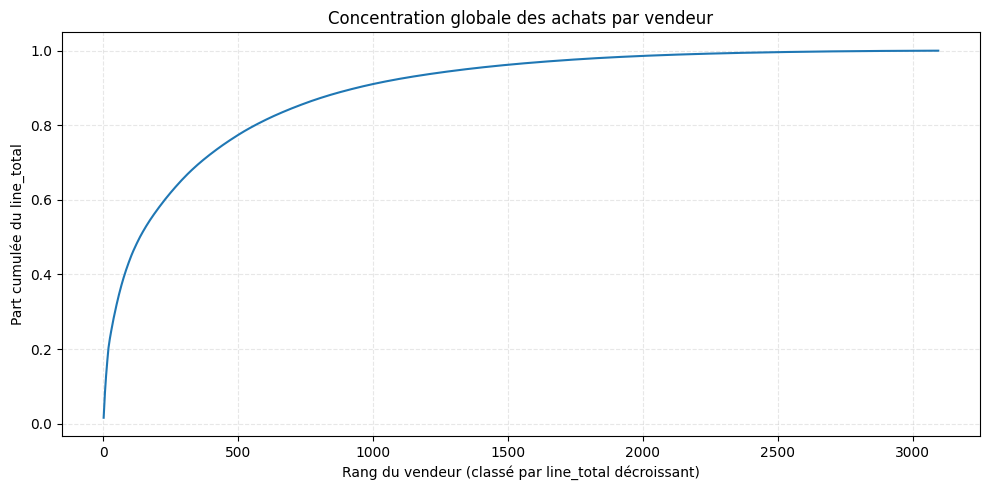

In [26]:
# 1 Concentration globale des achats par vendeur (Top sellers vs “long tail”)

# préparation
seller_sales = (
    F_ACHATS.groupby("seller_id")["line_total"]
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
seller_sales["rank"] = np.arange(1, len(seller_sales) + 1)
seller_sales["cum_share"] = seller_sales["line_total"].cumsum() / seller_sales["line_total"].sum()

# affichage
plt.figure(figsize=(10, 5))
sns.lineplot(data=seller_sales, x="rank", y="cum_share")
plt.xlabel("Rang du vendeur (classé par line_total décroissant)")
plt.ylabel("Part cumulée du line_total")
plt.title("Concentration globale des achats par vendeur")
plt.grid(True, axis="both", linestyle="--", alpha=0.3)
plt.tight_layout()


In [27]:
# On voit que quelques vendeurs font quasiment tout le boulot : la courbe monte très vite au début, puis se tasse.
# Donc oui, on a bien une poignée de gros vendeurs « stars » et une énorme longue traîne de petits.
# Ça colle avec notre hypothèse : la logistique doit surtout tourner autour de ces vendeurs structurants.
# La longue traîne, elle, ajoute surtout de la complexité (plein de petits points d’expédition pour peu de volume chacun).
# On s’attend donc à ce que les commandes mono-vendeur soient plutôt chez ces gros vendeurs, et les commandes éclatées dans la longue traîne.
# Les prochains graphes vont regarder ça de plus près, en lien avec les coûts de freight_value, les délais limit et les statuts de commande.


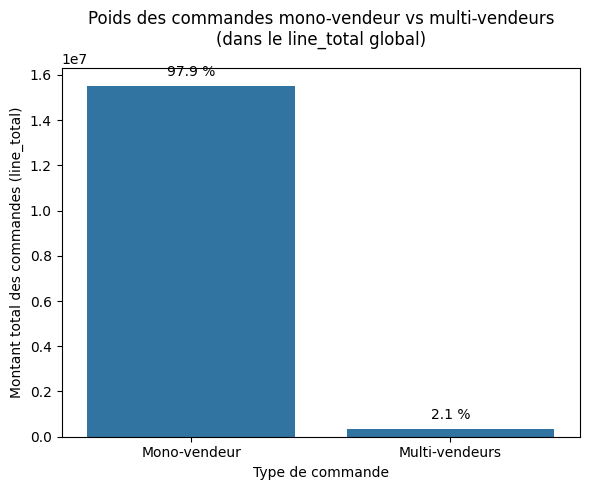

In [28]:
# 2 Poids des commandes mono-vendeur vs multi-vendeurs dans le line_total global
# préparation
orders_sellers = (
    F_ACHATS.groupby("order_id")["seller_id"]
    .nunique()
    .reset_index(name="seller_count")
)
orders_sellers["order_type"] = np.where(
    orders_sellers["seller_count"] == 1, "Mono-vendeur", "Multi-vendeurs"
)

order_totals = (
    F_ACHATS.groupby("order_id")["line_total"]
    .sum()
    .reset_index(name="order_total")
)

orders_type = orders_sellers.merge(order_totals, on="order_id", how="left")

type_agg = (
    orders_type.groupby("order_type")["order_total"]
    .sum()
    .reset_index()
    .sort_values("order_total", ascending=False)
)

# calcul des pourcentages
total_global = type_agg["order_total"].sum()
type_agg["pct"] = type_agg["order_total"] / total_global * 100

# affichage
plt.figure(figsize=(6, 5))
ax = sns.barplot(data=type_agg, x="order_type", y="order_total")
plt.xlabel("Type de commande")
plt.ylabel("Montant total des commandes (line_total)")
plt.title(
    "Poids des commandes mono-vendeur vs multi-vendeurs\n"
    "(dans le line_total global)"
)

# ajout des % au-dessus des barres
for bar, pct in zip(ax.patches, type_agg["pct"]):
    height = bar.get_height()
    ax.annotate(
        f"{pct:.1f} %",
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5),
        textcoords="offset points",
        ha="center",
        va="bottom"
    )

plt.tight_layout()


In [29]:
# On voit que presque tout le chiffre d’affaires vient des commandes avec un seul vendeur : envrion 98 % du line_total.  
# Les commandes qui mélangent plusieurs vendeurs pèsent à peine quelques pourcents, donc elles restent l’exception plutôt que la règle.  
# Ça va dans le même sens que ce qu’on a vu sur la concentration des ventes par seller_id : quelques vendeurs « stars » captent l’essentiel du business.  
# Pour Olist, ça veut dire que la logistique du quotidien ressemble surtout à des flux simples, un client ↔ un vendeur, avec des paniers assez « propres ».  
# Les paniers multi-vendeurs, eux, ne rapportent pas grand-chose en valeur mais peuvent générer beaucoup de boulot côté opérationnel (plus de colis, plus de points d’expédition, plus de suivi).  
# C’est justement sur ces commandes éclatées qu’on va regarder ensuite la part du freight_value, les délais limit et les statuts de commande, surtout pendant les périodes de pic déjà repérées dans les analyses précédentes.  


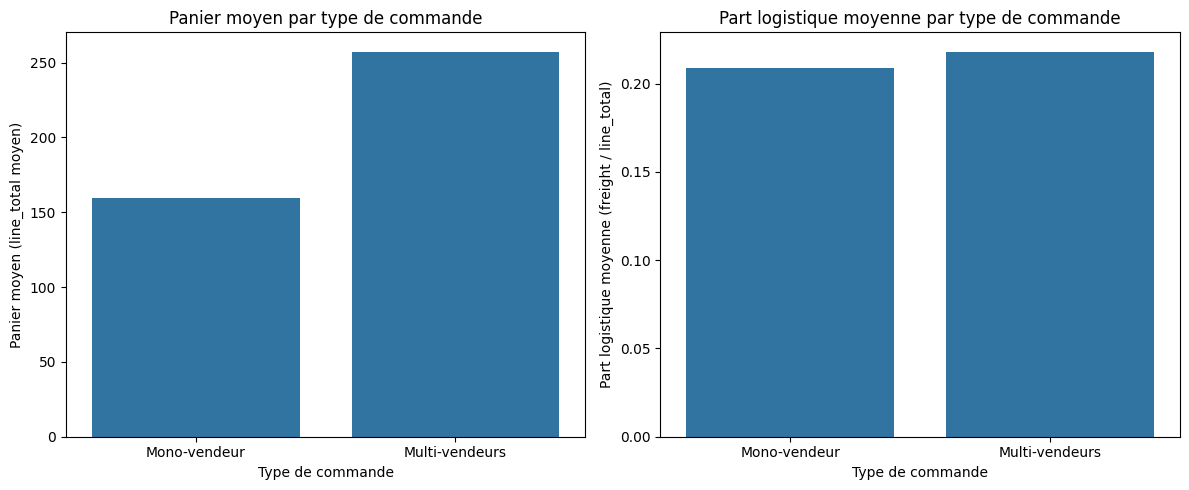

In [30]:
# 3 Panier moyen et part logistique selon le type de commande (mono-vendeur vs multi-vendeurs)
# préparation
orders_sellers = (
    F_ACHATS.groupby("order_id")["seller_id"]
    .nunique()
    .reset_index(name="seller_count")
)
orders_sellers["order_type"] = np.where(
    orders_sellers["seller_count"] == 1, "Mono-vendeur", "Multi-vendeurs"
)

order_metrics = (
    F_ACHATS.groupby("order_id")[["line_total", "freight_value"]]
    .sum()
    .reset_index()
)
order_metrics["freight_share"] = order_metrics["freight_value"] / order_metrics["line_total"]

orders_type = orders_sellers.merge(order_metrics, on="order_id", how="left")

type_stats = (
    orders_type.groupby("order_type")
    .agg(
        avg_basket=("line_total", "mean"),
        avg_freight_share=("freight_share", "mean"),
    )
    .reset_index()
)

# affichage
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(data=type_stats, x="order_type", y="avg_basket", ax=axes[0])
axes[0].set_xlabel("Type de commande")
axes[0].set_ylabel("Panier moyen (line_total moyen)")
axes[0].set_title("Panier moyen par type de commande")

sns.barplot(data=type_stats, x="order_type", y="avg_freight_share", ax=axes[1])
axes[1].set_xlabel("Type de commande")
axes[1].set_ylabel("Part logistique moyenne (freight / line_total)")
axes[1].set_title("Part logistique moyenne par type de commande")

plt.tight_layout()


In [31]:
# Les commandes multi-vendeurs affichent un panier moyen nettement plus élevé que les commandes mono-vendeur, ce qui renvoie à des paniers plus « lourds » ou plus diversifiés.
# En revanche, la part logistique moyenne reste assez proche entre les deux types : elle est un peu plus élevée en multi-vendeurs, mais sans explosion du poids du freight dans le panier.
# Cela suggère que la fragmentation entre plusieurs vendeurs renchérit légèrement la logistique, sans pour autant rendre ces commandes systématiquement désavantageuses en coût relatif.
# On retrouve ici le rôle des vendeurs structurants mis en évidence plus tôt : ils concentrent une grande partie du volume et contribuent à maintenir une efficacité logistique acceptable, même sur des paniers multi-vendeurs.
# À l’inverse, les commandes mono-vendeur, souvent portées par ces gros acteurs, gardent un panier moyen plus modeste avec une organisation logistique plus simple.
# Mis en regard avec la saisonnalité observée dans les analyses précédentes, on peut imaginer que les pics de demande se traduisent par davantage de paniers multi-vendeurs à forte valeur.
# La prochaine étape consiste à vérifier si ces paniers plus gros et fragmentés se traduisent aussi par des délais limit plus tendus et une probabilité plus forte de statuts défavorables (shipped en retard, canceled, etc.).


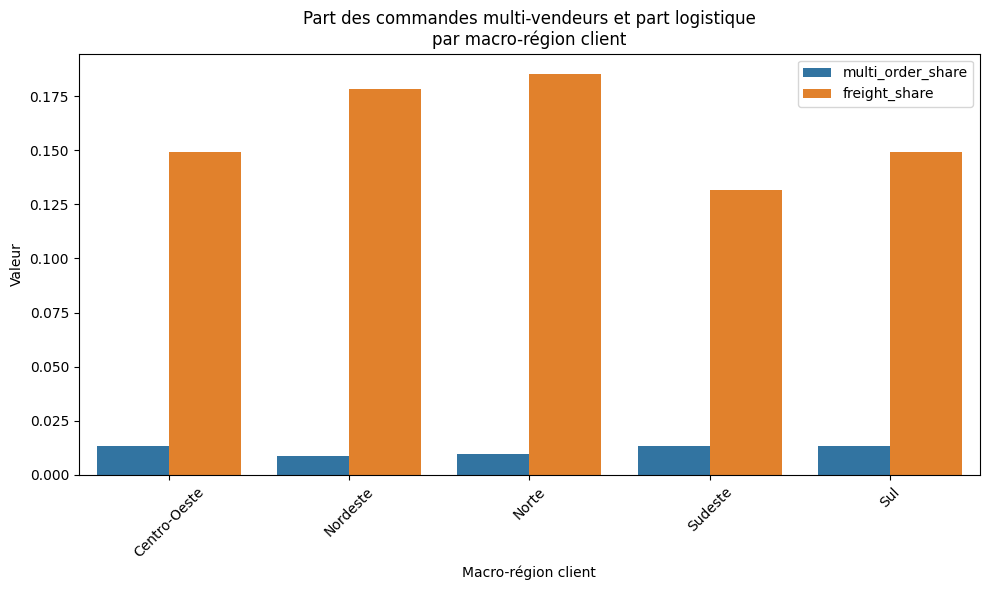

In [32]:
# 4 Part des commandes multi-vendeurs et part logistique par macro-région client
# préparation
orders_sellers = (
    F_ACHATS.groupby("order_id")["seller_id"]
    .nunique()
    .reset_index(name="seller_count")
)
orders_sellers["order_type"] = np.where(
    orders_sellers["seller_count"] == 1, "Mono-vendeur", "Multi-vendeurs"
)

order_metrics = (
    F_ACHATS.groupby("order_id")[["line_total", "freight_value"]]
    .sum()
    .reset_index()
)

orders_cust = (
    F_ACHATS[["order_id", "customer_id"]]
    .drop_duplicates()
    .merge(
        cust_dim[["customer_id", "macro_region"]],
        on="customer_id",
        how="left",
    )
)

orders_full = (
    orders_cust
    .merge(orders_sellers[["order_id", "order_type"]], on="order_id", how="left")
    .merge(order_metrics, on="order_id", how="left")
)

region_stats = (
    orders_full.dropna(subset=["macro_region"])
    .groupby("macro_region")
    .agg(
        total_orders=("order_id", "nunique"),
        multi_orders=("order_type", lambda x: (x == "Multi-vendeurs").sum()),
        freight_sum=("freight_value", "sum"),
        line_total_sum=("line_total", "sum"),
    )
    .reset_index()
)
region_stats["multi_order_share"] = region_stats["multi_orders"] / region_stats["total_orders"]
region_stats["freight_share"] = region_stats["freight_sum"] / region_stats["line_total_sum"]

plot_df = region_stats.melt(
    id_vars="macro_region",
    value_vars=["multi_order_share", "freight_share"],
    var_name="metric",
    value_name="value",
)

# affichage
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x="macro_region", y="value", hue="metric")
plt.xlabel("Macro-région client")
plt.ylabel("Valeur")
plt.title("Part des commandes multi-vendeurs et part logistique\npar macro-région client")
plt.xticks(rotation=45)
plt.legend(title="")
plt.tight_layout()


In [33]:
# On voit d’abord que la part de commandes multi-vendeurs reste faible et assez homogène entre macro-régions, autour d’un petit pourcentage de l’ensemble des commandes.
# À l’inverse, la part logistique dans le panier (freight_share) varie beaucoup plus : elle est nettement plus élevée dans le Nord et le Nordeste, et plus faible dans le Sudeste.
# Cela suggère que le surcoût logistique est d’abord lié à la distance et aux contraintes d’infrastructure des régions périphériques, plus qu’au simple fait de fragmenter une commande entre plusieurs vendeurs.
# Mis en perspective avec les résultats précédents, où quelques vendeurs structurants concentraient le volume, on peut imaginer qu’ils absorbent une partie de cette complexité dans les régions les mieux desservies.
# Dans le Sudeste, cœur économique du pays, la combinaison gros vendeurs + réseau logistique dense semble permettre de contenir la part de freight même quand il y a des paniers multi-vendeurs.
# À l’inverse, dans le Nord et le Nordeste, une commande fragmentée entre plusieurs vendeurs risque de se cumuler avec des distances plus longues, ce qui renchérit mécaniquement le poids du transport dans le panier.
# Ces écarts géographiques rejoignent l’analyse globale : la complexité logistique ne vient pas seulement des produits et des vendeurs, mais aussi de la localisation du client et de la structure des flux entre régions.


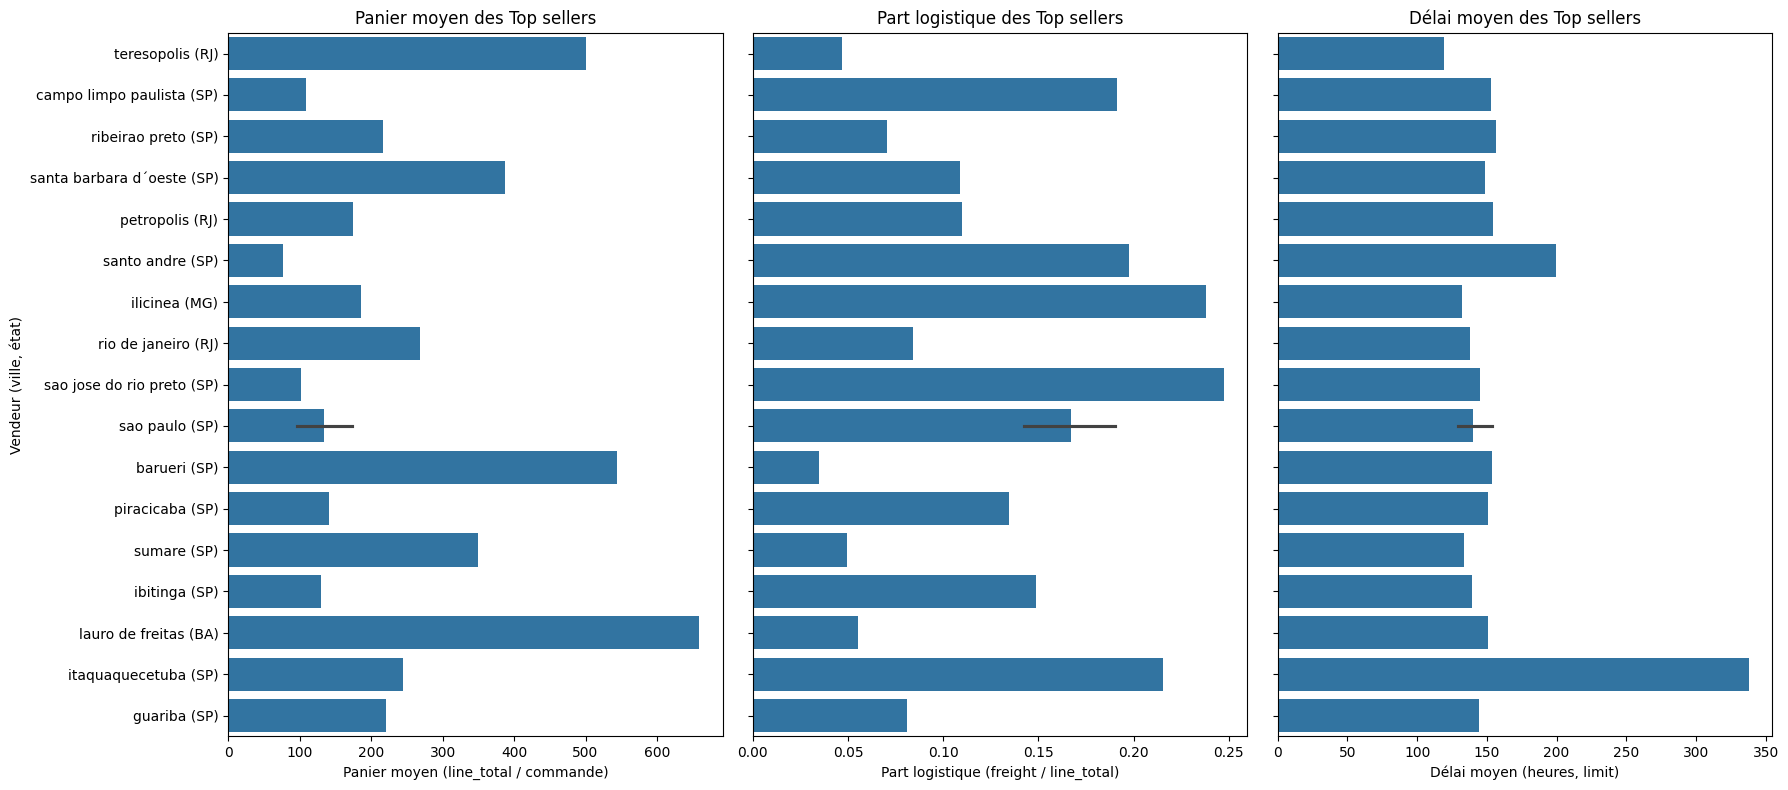

In [34]:
# 5 Performance logistique des Top sellers : panier moyen, part logistique et délai moyen par vendeur
# préparation
seller_stats = (
    F_ACHATS.groupby("seller_id")
    .agg(
        total_line=("line_total", "sum"),
        total_freight=("freight_value", "sum"),
        avg_limit=("limit", "mean"),
        n_orders=("order_id", "nunique"),
    )
    .reset_index()
)
seller_stats["avg_basket"] = seller_stats["total_line"] / seller_stats["n_orders"]
seller_stats["freight_share"] = seller_stats["total_freight"] / seller_stats["total_line"]

top_sellers = (
    seller_stats.sort_values("total_line", ascending=False)
    .head(20)
    .merge(sellers[["seller_id", "city", "state"]], on="seller_id", how="left")
)

top_sellers["seller_label"] = (
    top_sellers["city"].fillna("NA") + " (" + top_sellers["state"].fillna("") + ")"
)

top_sellers = top_sellers.sort_values("total_line", ascending=True)
order_labels = top_sellers["seller_label"].tolist()

# affichage
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

sns.barplot(
    data=top_sellers,
    x="avg_basket",
    y="seller_label",
    ax=axes[0],
    orient="h",
    order=order_labels,
)
axes[0].set_xlabel("Panier moyen (line_total / commande)")
axes[0].set_ylabel("Vendeur (ville, état)")
axes[0].set_title("Panier moyen des Top sellers")

sns.barplot(
    data=top_sellers,
    x="freight_share",
    y="seller_label",
    ax=axes[1],
    orient="h",
    order=order_labels,
)
axes[1].set_xlabel("Part logistique (freight / line_total)")
axes[1].set_ylabel("")
axes[1].set_title("Part logistique des Top sellers")

sns.barplot(
    data=top_sellers,
    x="avg_limit",
    y="seller_label",
    ax=axes[2],
    orient="h",
    order=order_labels,
)
axes[2].set_xlabel("Délai moyen (heures, limit)")
axes[2].set_ylabel("")
axes[2].set_title("Délai moyen des Top sellers")

plt.tight_layout()


In [35]:
# Parmi les Top sellers, on retrouve surtout des villes du Sudeste, avec des paniers moyens très variés, de l’ordre de 150 à plus de 600 R$ par commande.
# Les vendeurs au panier le plus élevé ne sont pas forcément ceux qui supportent la part logistique la plus forte : le freight reste globalement contenu sous 20 % du line_total.
# Certains vendeurs combinent panier important et freight_share faible, ce qui traduit une logistique bien optimisée et un effet d’échelle sur les volumes traités.
# À l’inverse, quelques Top sellers affichent un délai moyen (limit) nettement plus long, au-delà de 250–300 heures, signe de contraintes géographiques ou opérationnelles plus fortes.
# Les vendeurs situés dans les grands hubs (comme São Paulo et sa périphérie) se situent plutôt dans une zone « confortable » : panier correct, freight_share modéré et délais proches de la moyenne.
# Ce profil confirme l’idée de vendeurs structurants autour desquels s’organise la logistique : ils concentrent le volume tout en gardant un bon compromis entre prix, coût de transport et délai.
# Mis en regard avec la longue traîne de petits vendeurs mise en évidence précédemment, ces résultats suggèrent que l’essentiel de la performance logistique du marché dépend de quelques acteurs clés.


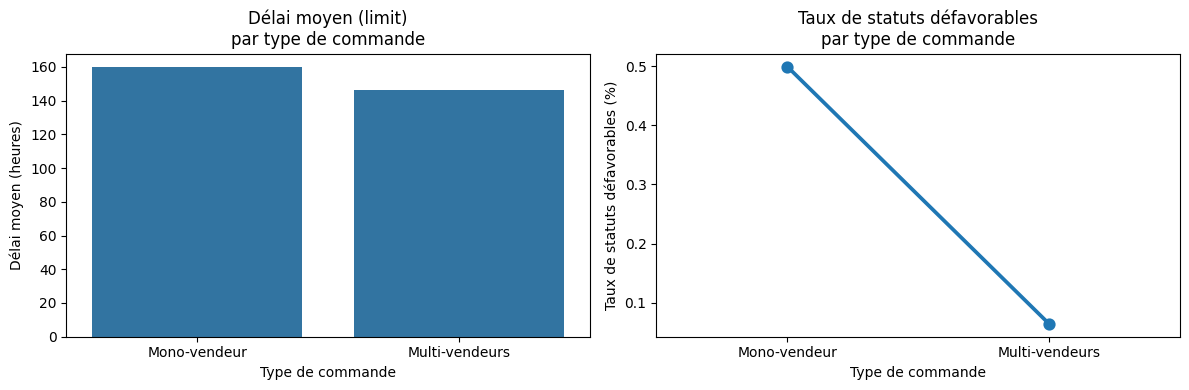

In [36]:
# 6 Impact de la fragmentation sur les délais et statuts :
#    délai limit moyen et taux de statuts défavorables selon le type de commande

# préparation
orders_sellers = (
    F_ACHATS.groupby("order_id")["seller_id"]
    .nunique()
    .reset_index(name="seller_count")
)
orders_sellers["order_type"] = np.where(
    orders_sellers["seller_count"] == 1, "Mono-vendeur", "Multi-vendeurs"
)

lines = F_ACHATS.merge(
    orders_sellers[["order_id", "order_type"]],
    on="order_id",
    how="left",
)

bad_statuses = ["canceled", "unavailable"]
lines["defav"] = lines["order_status"].str.lower().isin(bad_statuses).astype(int)

impact_stats = (
    lines.groupby("order_type")
    .agg(
        avg_limit=("limit", "mean"),
        defav_rate=("defav", "mean"),
    )
    .reset_index()
)

# passage du taux défavorable en pourcentage pour un affichage lisible
impact_stats["defav_rate_pct"] = impact_stats["defav_rate"] * 100

# affichage : deux sous-graphiques séparés
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# 1) Délai moyen "limit" par type de commande (barres)
sns.barplot(data=impact_stats, x="order_type", y="avg_limit", ax=axes[0])
axes[0].set_xlabel("Type de commande")
axes[0].set_ylabel("Délai moyen (heures)")
axes[0].set_title("Délai moyen (limit)\npar type de commande")

# 2) Taux de statuts défavorables par type de commande (points)
sns.pointplot(
    data=impact_stats,
    x="order_type",
    y="defav_rate_pct",
    ax=axes[1],
    markers="o",
    linestyles="-",
)
axes[1].set_xlabel("Type de commande")
axes[1].set_ylabel("Taux de statuts défavorables (%)")
axes[1].set_title("Taux de statuts défavorables\npar type de commande")

plt.tight_layout()


In [37]:
# Ce double graphique montre que les commandes multi-vendeurs n’ont pas un délai contractuel plus tendu : leur limit moyen est même légèrement plus court que pour les commandes mono-vendeur.  
# L’écart reste modeste (une quinzaine d’heures), ce qui confirme que la plateforme fixe des objectifs de livraison assez homogènes, quel que soit le nombre de vendeurs impliqués.  
# Plus surprenant, le taux de statuts défavorables (canceled, unavailable) est plus élevé pour les commandes mono-vendeur que pour les commandes multi-vendeurs.  
# Cela suggère que la fragmentation en plusieurs vendeurs ne se traduit pas par plus d’incidents déclarés, sans doute parce que les paniers multi-vendeurs passent souvent par les gros vendeurs structurants identifiés plus tôt.  
# À l’inverse, une partie des commandes mono-vendeur semble portée par la longue traîne de petits sellers, plus exposés aux ruptures ou annulations, ce qui explique ce taux défavorable légèrement supérieur.  
# Mis en regard des analyses précédentes sur la valeur de panier et la part logistique, les paniers multi-vendeurs cumulent forte valeur et complexité, mais restent globalement bien maîtrisés en termes de délai et de statut.  
# Pour l’analyse globale, cela renforce l’idée que les principaux risques logistiques ne viennent pas tant du nombre de vendeurs par commande que de la structure du réseau de vendeurs (gros hubs vs petite longue traîne) et de leur localisation géographique.  


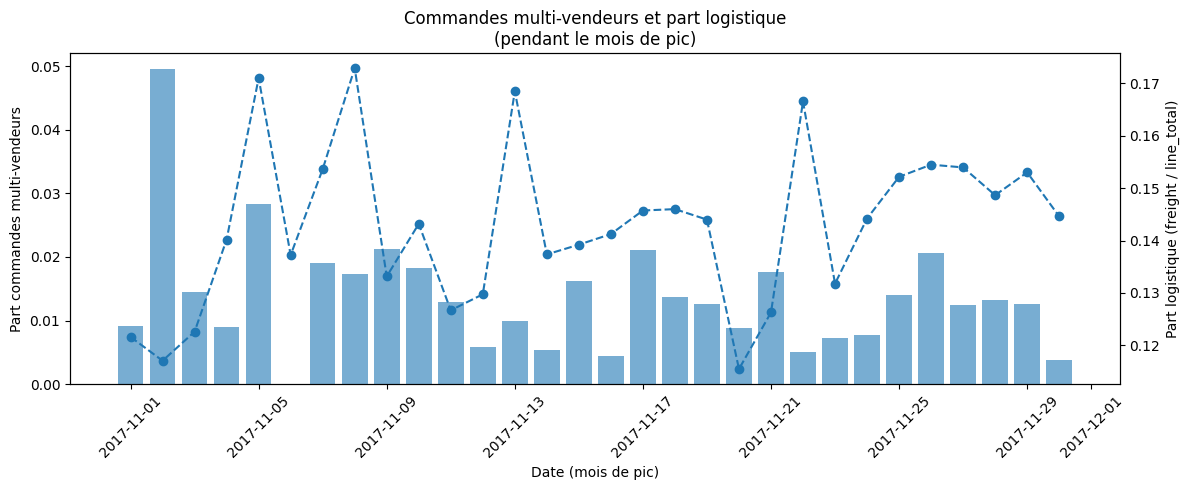

In [40]:
fig, ax1 = plt.subplots(figsize=(12, 5))

# Barres = part de commandes multi-vendeurs
ax1.bar(daily_stats["date"], daily_stats["multi_order_share"], alpha=0.6)
ax1.set_ylabel("Part commandes multi-vendeurs")
ax1.set_xlabel("Date (mois de pic)")
plt.xticks(rotation=45)

# Axe secondaire pour la part logistique
ax2 = ax1.twinx()
ax2.plot(daily_stats["date"], daily_stats["freight_share"], marker="o", linestyle="--")
ax2.set_ylabel("Part logistique (freight / line_total)")

plt.title("Commandes multi-vendeurs et part logistique\n(pendant le mois de pic)")
plt.tight_layout()
plt.show()


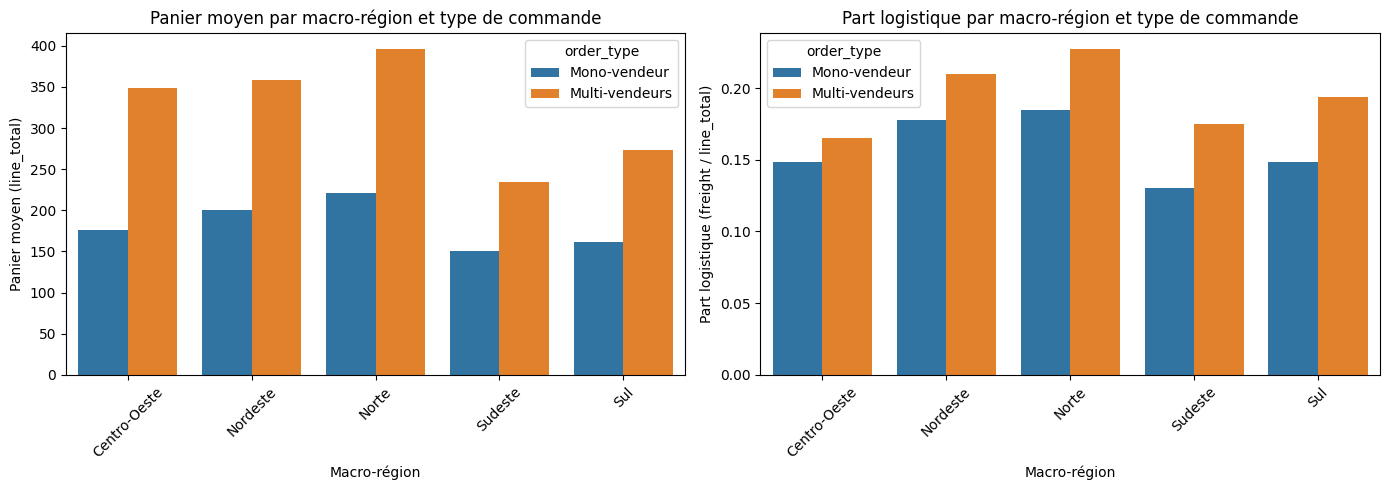

In [15]:
# 8 Segments géographiques critiques : panier moyen et part logistique selon macro-région × type de commande
# préparation
orders_sellers = (
    F_ACHATS.groupby("order_id")["seller_id"]
    .nunique()
    .reset_index(name="seller_count")
)
orders_sellers["order_type"] = np.where(
    orders_sellers["seller_count"] == 1, "Mono-vendeur", "Multi-vendeurs"
)

order_metrics = (
    F_ACHATS.groupby("order_id")[["line_total", "freight_value"]]
    .sum()
    .reset_index()
)

orders_cust = (
    F_ACHATS[["order_id", "customer_id"]]
    .drop_duplicates()
    .merge(
        cust_dim[["customer_id", "macro_region"]],
        on="customer_id",
        how="left",
    )
)

orders_full = (
    orders_cust
    .merge(orders_sellers[["order_id", "order_type"]], on="order_id", how="left")
    .merge(order_metrics, on="order_id", how="left")
)

seg_stats = (
    orders_full.dropna(subset=["macro_region", "order_type"])
    .groupby(["macro_region", "order_type"])
    .agg(
        total_line=("line_total", "sum"),
        total_freight=("freight_value", "sum"),
        avg_order_total=("line_total", "mean"),
    )
    .reset_index()
)
seg_stats["freight_share"] = seg_stats["total_freight"] / seg_stats["total_line"]

# affichage
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

sns.barplot(
    data=seg_stats,
    x="macro_region",
    y="avg_order_total",
    hue="order_type",
    ax=axes[0],
)
axes[0].set_xlabel("Macro-région")
axes[0].set_ylabel("Panier moyen (line_total)")
axes[0].set_title("Panier moyen par macro-région et type de commande")
axes[0].tick_params(axis="x", rotation=45)

sns.barplot(
    data=seg_stats,
    x="macro_region",
    y="freight_share",
    hue="order_type",
    ax=axes[1],
)
axes[1].set_xlabel("Macro-région")
axes[1].set_ylabel("Part logistique (freight / line_total)")
axes[1].set_title("Part logistique par macro-région et type de commande")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()


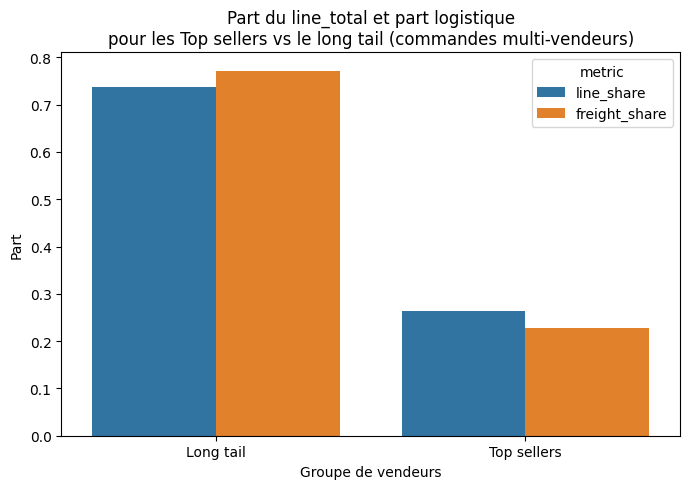

In [16]:
# 9 Rôle des “gros vendeurs” dans les commandes multi-vendeurs : part du line_total et part logistique Top sellers vs “long tail”
# préparation
seller_totals = (
    F_ACHATS.groupby("seller_id")["line_total"]
    .sum()
    .sort_values(ascending=False)
)
top_seller_ids = set(seller_totals.head(50).index)

orders_sellers = (
    F_ACHATS.groupby("order_id")["seller_id"]
    .nunique()
    .reset_index(name="seller_count")
)
multi_orders = orders_sellers.loc[orders_sellers["seller_count"] > 1, "order_id"]

F_multi = F_ACHATS[F_ACHATS["order_id"].isin(multi_orders)].copy()
F_multi["seller_group"] = np.where(
    F_multi["seller_id"].isin(top_seller_ids),
    "Top sellers",
    "Long tail",
)

group_stats = (
    F_multi.groupby("seller_group")
    .agg(
        line_sum=("line_total", "sum"),
        freight_sum=("freight_value", "sum"),
    )
    .reset_index()
)
group_stats["line_share"] = group_stats["line_sum"] / group_stats["line_sum"].sum()
group_stats["freight_share"] = group_stats["freight_sum"] / group_stats["freight_sum"].sum()

plot_df = group_stats.melt(
    id_vars="seller_group",
    value_vars=["line_share", "freight_share"],
    var_name="metric",
    value_name="value",
)

# affichage
plt.figure(figsize=(7, 5))
sns.barplot(data=plot_df, x="seller_group", y="value", hue="metric")
plt.xlabel("Groupe de vendeurs")
plt.ylabel("Part")
plt.title("Part du line_total et part logistique\npour les Top sellers vs le long tail (commandes multi-vendeurs)")
plt.tight_layout()
